In [1]:
#!/usr/bin/env python

import math
import healpy as hp
import numpy as np
import sys
import time
import os
sys.path.insert(1, '../../../PySSC/')

from classy import Class
import PySSC
from scipy.stats import norm
from matplotlib import pyplot as plt

from numcosmo_py import Ncm, Nc

Ncm.cfg_init()
Ncm.cfg_set_log_handler(lambda msg: sys.stdout.write(msg) and sys.stdout.flush())

In [2]:
cosmo = Nc.HICosmoDEXcdm()
cosmo.props.H0 = 67.81
cosmo.props.Omegac = 0.2612
cosmo.props.Omegab = 0.0486
cosmo.props.Omegax = 1 - 0.0486 - 0.2612
cosmo.props.w = -1.0

reion = Nc.HIReionCamb.new()
prim = Nc.HIPrimPowerLaw.new()

cosmo.add_submodel(reion)
cosmo.add_submodel(prim)

dist = Nc.Distance.new(2.0)

tf = Nc.TransferFunc.new_from_name("NcTransferFuncEH")

psml = Nc.PowspecMLTransfer.new(tf)
psml.require_kmin(1.0e-6)
psml.require_kmax(1.0e3)

psf = Ncm.PowspecFilter.new(psml, Ncm.PowspecFilterType.TOPHAT)
psf.set_best_lnr0()
prim.props.n_SA = 0.9660
# print(0.82505858,cosmo.sigma8(psf),cosmo.Omega_k0())

prim.props.ln10e10ASA = 3.027449698161606
# print(0.82505858, cosmo.sigma8(psf))

z_obs = Ncm.Vector.new_array(np.linspace(0.1, 0.8, 8))
lnM_obs = Ncm.Vector.new_array(np.linspace(np.log(10) * 14.0, np.log(10) * 15, 2))

print(z_obs.dup_array())
print(lnM_obs.dup_array())
print(prim.props.ln10e10ASA)

[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7000000000000001, 0.8]
[32.23619130191664, 34.53877639491069]
3.027449698161606


# Construct the $S_{ij}$  Matrix

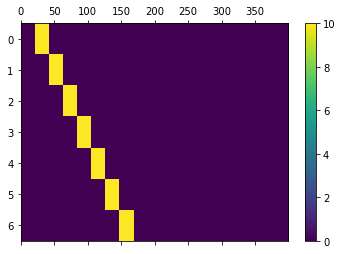

In [3]:
nz = 400
z_arr = np.linspace(0, 1.9, num=nz + 1)[1:]

nbins_T = z_obs.len() - 1

kernels_T = np.zeros((nbins_T, nz))
for i in range(nbins_T):
    zminbin = z_obs.get(i)
    zmaxbin = z_obs.get(i + 1)
    Dz = zmaxbin - zminbin

    for iz in range(nz):
        z = z_arr[iz]
        if (z > zminbin) and (z <= zmaxbin):
            kernels_T[i, iz] = 1 / Dz

fig = plt.figure()
ax = fig.add_subplot(111)

im = ax.matshow(kernels_T)
ax.set_aspect("auto")
plt.colorbar(im)
pass

In [4]:
NSIDE = 2 * 512
NPIX = hp.nside2npix(NSIDE)
m = np.zeros(hp.nside2npix(NSIDE))
pix_theta_ecl, pix_phi_ecl = hp.pix2ang(NSIDE, np.arange(NPIX))

# Guaranteed mask
mask1_guaranteed = np.zeros(NPIX)
mask2_guaranteed = np.zeros(NPIX)
mask3_guaranteed = np.zeros(NPIX)

mask1_guaranteed_condition = (
    (pix_phi_ecl > 3.0 * np.pi / 4.0)
    & (pix_phi_ecl < 13.0 * np.pi / 12.0)
    & (pix_theta_ecl < np.pi / 2.0 - 30.0 * np.pi / 180)
    & (pix_theta_ecl > np.pi / 2.0 - 80.0 * np.pi / 180)
)
mask2_guaranteed_condition = (
    (pix_phi_ecl > 11.0 * np.pi / 6.0)
    & (pix_theta_ecl < np.pi / 2.0 - 20.0 * np.pi / 180)
    & (pix_theta_ecl > np.pi / 2.0 - 40.0 * np.pi / 180)
)
mask3_guaranteed_condition = (
    (pix_phi_ecl < np.pi / 4.0)
    & (pix_theta_ecl < np.pi / 2.0 - 20.0 * np.pi / 180)
    & (pix_theta_ecl > np.pi / 2.0 - 40.0 * np.pi / 180)
)

mask1_guaranteed[mask1_guaranteed_condition] = 1
mask2_guaranteed[mask2_guaranteed_condition] = 1
mask3_guaranteed[mask3_guaranteed_condition] = 1

mask_guaranteed = mask1_guaranteed + mask2_guaranteed + mask3_guaranteed

# Total mask
mask1_full = np.zeros(NPIX)
mask2_full = np.zeros(NPIX)
mask3_full = np.zeros(NPIX)

mask1_full_condition = (
    (pix_phi_ecl > 2.0 * np.pi / 3.0)
    & (pix_phi_ecl < 3.0 * np.pi / 2.0)
    & (pix_theta_ecl < np.pi / 2.0 - 10.0 * np.pi / 180)
    & (pix_theta_ecl > np.pi / 2.0 - 80.0 * np.pi / 180)
)
mask2_full_condition = (
    (pix_phi_ecl > 11.0 * np.pi / 6.0)
    & (pix_theta_ecl < np.pi / 2.0)
    & (pix_theta_ecl > np.pi / 2.0 - 45.0 * np.pi / 180)
)
mask3_full_condition = (
    (pix_phi_ecl < np.pi / 4.0)
    & (pix_theta_ecl < np.pi / 2.0)
    & (pix_theta_ecl > np.pi / 2.0 - 45.0 * np.pi / 180)
)

mask1_full[mask1_full_condition] = 1
mask2_full[mask2_full_condition] = 1
mask3_full[mask3_full_condition] = 1

mask_full = mask1_full + mask2_full + mask3_full

`S matrices`

In [8]:
# Full sky
t0 = time.time()
S_lacasa_full = PySSC.Sij(z_arr, kernels_T, cosmo_Class=cosmo)
t1 = time.time()
print("Full sky time (seconds) = " + str(t1 - t0))

S_full = Ncm.Matrix.new(S_lacasa_full.shape[0], S_lacasa_full.shape[1])
for i in range(len(S_lacasa_full)):
    for j in range(len(S_lacasa_full[i])):
        S_full.set(i, j, S_lacasa_full[i][j])


# Partial-Sky guaranteed
t0 = time.time()
S_lacasa_guaranteed = PySSC.Sij_psky(z_arr, kernels_T, mask=mask_guaranteed, cosmo_Class=cosmo)
t1 = time.time()
print("Partial sky guaranteed time (seconds) = " + str(t1 - t0))

S_partial_guaranteed = Ncm.Matrix.new(S_lacasa_guaranteed.shape[0], S_lacasa_guaranteed.shape[1])
for i in range(len(S_lacasa_guaranteed)):
    for j in range(len(S_lacasa_guaranteed[i])):
        S_partial_guaranteed.set(i, j, S_lacasa_guaranteed[i][j])


# Partial-Sky maximal
t0 = time.time()
S_lacasa_maximal = PySSC.Sij_psky(z_arr, kernels_T, mask=mask_full, cosmo_Class=cosmo)
t1 = time.time()
print("Partial sky maximal time (seconds) = " + str(t1 - t0))

S_partial_maximal = Ncm.Matrix.new(S_lacasa_maximal.shape[0], S_lacasa_maximal.shape[1])
for i in range(len(S_lacasa_maximal)):
    for j in range(len(S_lacasa_maximal[i])):
        S_partial_maximal.set(i, j, S_lacasa_maximal[i][j])

Full sky time (seconds) = 0.6698095798492432
Partial sky guaranteed time (seconds) = 39.1605544090271
Partial sky maximal time (seconds) = 23.96400022506714
49
S_maximal: 0.0000928190 -0.0000059164 -0.0000012549 -0.0000003363 -0.0000001441 -0.0000000565 -0.0000000235
S_maximal: -0.0000059164 0.0000327906 -0.0000033070 -0.0000007983 -0.0000002389 -0.0000001051 -0.0000000507
S_maximal: -0.0000012549 -0.0000033070 0.0000165310 -0.0000020944 -0.0000005734 -0.0000001849 -0.0000000837
S_maximal: -0.0000003363 -0.0000007983 -0.0000020944 0.0000100162 -0.0000014396 -0.0000004422 -0.0000001510
S_maximal: -0.0000001441 -0.0000002389 -0.0000005734 -0.0000014396 0.0000067851 -0.0000010464 -0.0000003581
S_maximal: -0.0000000565 -0.0000001051 -0.0000001849 -0.0000004422 -0.0000010464 0.0000049504 -0.0000007915
S_maximal: -0.0000000235 -0.0000000507 -0.0000000837 -0.0000001510 -0.0000003581 -0.0000007915 0.0000038049
49
S_guaranteed: 0.0003347933 -0.0000076788 -0.0000019727 -0.0000004600 -0.000000206

# Define proxy modelling

In [ ]:
cluster_m = Nc.ClusterMassNodist(lnM_min=np.log(10) * 14.0, lnM_max=np.log(10) * 16 )
cluster_z = Nc.ClusterRedshiftNodist(z_min=0.0, z_max=2.0)

# Initialize the `ClusterAbundance` object

In [ ]:
mulf = Nc.MultiplicityFuncTinker.new()
mulf.set_mdef(Nc.MultiplicityFuncMassDef.CRITICAL)
mulf.set_Delta(200.0)

hmf = Nc.HaloMassFunction.new(dist, psf, mulf)
hbias_Tinker = Nc.HaloBiasTinker.new(hmf)
cad = Nc.ClusterAbundance.new(hmf, hbias_Tinker)

# Data model

$f(x_i)$ for the Gaussian distribution $$-2\ln L = \sum_{ij}\left[(f(x_i) - y_i)C^{-1}_{ij}(f(x_j) - y_j)\right] + \dots$$

In [ ]:
mset = Ncm.MSet.new_array([cosmo,cluster_m,cluster_z])


ncounts_gauss = Nc.DataClusterNCountsGauss.new(cad)
ncounts_gauss.set_size((z_obs.len()-1)*(lnM_obs.len()-1))
ncounts_gauss.set_init(True)
ncounts_gauss.set_fix_cov(False)
ncounts_gauss.use_norma(True)
ncounts_gauss.set_z_obs(z_obs)
ncounts_gauss.set_lnM_obs(lnM_obs)
rng = Ncm.RNG.seeded_new (None, 42)
print(ncounts_gauss.get_fix_cov()) 

False


# Creating the fit object and calculating the MC

`No SSC`

In [ ]:
print("No SSC")

mset_nossc = mset.dup()
guaranteed_area = 2959.1
cad.set_area(guaranteed_area * (np.pi / 180) ** 2)
ncounts_gauss.set_has_ssc(False)
ncounts_gauss.resample(mset_nossc, rng)
ncounts_gauss.peek_mean().log_vals("y: ", "% 22.15g", True)
ncounts_gauss.peek_cov().log_vals("cov: ", "% 22.15g")

dset = Ncm.Dataset.new()
dset.append_data(ncounts_gauss)


cosmo.props.Omegac_fit = True
cosmo.props.Omegab_fit = False
cosmo.props.w_fit = True
# cosmo.props.H0_fit = True
prim.props.ln10e10ASA_fit = True
mfunc_oa = Ncm.ObjArray.new()
mfunc_sigma8 = Ncm.MSetFuncList.new("NcHICosmo:sigma8", psf)
mfunc_oa.add(mfunc_sigma8)
print(mfunc_sigma8.eval0(mset_nossc))

mset_nossc.prepare_fparam_map()


lh = Ncm.Likelihood.new(dset)

fit = Ncm.Fit.new(
    Ncm.FitType.NLOPT, "ln-neldermead", lh, mset_nossc, Ncm.FitGradType.NUMDIFF_FORWARD
)

init_sampler = Ncm.MSetTransKernGauss.new(0)
init_sampler.set_mset(mset_nossc)
init_sampler.set_prior_from_mset()
init_sampler.set_cov_from_rescale(1.0)  # 1


nwalkers = int(math.ceil(200))  # 500
ssize = 200000  # 1000000

fitmc = Ncm.FitMC.new(fit, Ncm.FitMCResampleType.FROM_MODEL, Ncm.FitRunMsgs.SIMPLE)
fitmc.set_nthreads(3)

fitmc.set_data_file("mc_nossc.fits")

fitmc.start_run()
fitmc.run(ssize/nwalkers)
fitmc.end_run()

print("Full sky maximal time (seconds) = " + str(t1 - t0))

ncounts_gauss.peek_mean().log_vals("y: ", "%.3f", True)
ncounts_gauss.peek_cov().cov_dup_cor().log_vals("cov:", "%.3f")


No SSC
y:       1404.48257636951       3188.88172345454       4912.77079830035       6414.27963953379       7190.94067360189        7419.3108729704       7193.34466396361
cov:        1451.02844822162                      0                      0                      0                      0                      0                      0
cov:                       0        3238.3698073803                      0                      0                      0                      0                      0
cov:                       0                      0       5025.38346233246                      0                      0                      0                      0
cov:                       0                      0                      0           6399.3104724                      0                      0                      0
cov:                       0                      0                      0                      0       7185.56470314239                      0                  

In [ ]:
ntests = 100.0
mcat = fitmc.mcat

mcat.log_current_chain_stats()
mcat.calc_max_ess_time(ntests, Ncm.FitRunMsgs.FULL)
mcat.calc_heidel_diag(ntests, 0.0, Ncm.FitRunMsgs.FULL)

mset_nossc.pretty_log()
mcat.log_full_covar()
mcat.log_current_stats()

be, post_lnnorm_sd = mcat.get_post_lnnorm()
lnevol, glnvol = mcat.get_post_lnvol(0.6827)

Ncm.cfg_msg_sepa()
print(
    "# Bayesian evidence:                                 % 22.15g +/- % 22.15g"
    % (be, post_lnnorm_sd)
)
print("# 1 sigma posterior volume:                          % 22.15g" % lnevol)
print("# 1 sigma posterior volume (Gaussian approximation): % 22.15g" % glnvol)

#----------------------------------------------------------------------------------
# NcmMSetCatalog: Calculating catalog effective sample size from chain 1000 => 0 using 100 blocks:


# NcmMSetCatalog: - best cutoff time:         0   
# NcmMSetCatalog: - total number of points:   1000
# NcmMSetCatalog: - number of points left:    1000
# NcmMSetCatalog: - worst parameter:          NcmFit:m2lnL[00]
# NcmMSetCatalog: - worst parameter ess:      1100.42
# NcmMSetCatalog: - worst parameter ar order: 2   
# NcmMSetCatalog: - ess's:                    1100.42 1161.31 1213.01 1007.87
#----------------------------------------------------------------------------------
# NcmMSetCatalog: Applying the Heidelberger and Welch's convergence diagnostic from chain 1000 => 0 using 100 blocks:
# NcmMSetCatalog: - best cutoff time:         0   
# NcmMSetCatalog: - worst parameter:          NcHIPrim:ln10e10ASA[03]
# NcmMSetCatalog: - worst parameter pvalue:   38.30%
# NcmMSetCatalog: - worst parameter ar order: 0   
# NcmMSetCatalog: - target pvalue:             1.70%
# NcmMSetCatalog: - pvalues:                  96.37% 89.38% 72.46% 38.30%
#----------------------------------------------

`Full-Sky`

In [ ]:
print("Full Sky")

mset_fullsky = mset.dup()
guaranteed_area = 2959.1
cad.set_area(guaranteed_area * (np.pi / 180) ** 2)
ncounts_gauss.set_has_ssc(True)
ncounts_gauss.set_s_matrix(S_full)
ncounts_gauss.resample(mset_fullsky, rng)
ncounts_gauss.peek_mean().log_vals("y: ", "% 22.15g", True)
ncounts_gauss.peek_cov().log_vals("cov: ", "% 22.15g")

to_fix_cov = ncounts_gauss.peek_cov()

dset = Ncm.Dataset.new()
dset.append_data(ncounts_gauss)


cosmo.props.Omegac_fit = True
cosmo.props.Omegab_fit = False
cosmo.props.w_fit = True
# cosmo.props.H0_fit = True
prim.props.ln10e10ASA_fit = True
mfunc_oa = Ncm.ObjArray.new()
mfunc_sigma8 = Ncm.MSetFuncList.new("NcHICosmo:sigma8", psf)
mfunc_oa.add(mfunc_sigma8)
print(mfunc_sigma8.eval0(mset_fullsky))

mset_fullsky.prepare_fparam_map()


lh = Ncm.Likelihood.new(dset)

fit = Ncm.Fit.new(
    Ncm.FitType.NLOPT, "ln-neldermead", lh, mset_fullsky, Ncm.FitGradType.NUMDIFF_FORWARD
)

nwalkers = int(math.ceil(200))  # 500
ssize = 400000  # 1000000

fitmc = Ncm.FitMC.new(fit, Ncm.FitMCResampleType.FROM_MODEL, Ncm.FitRunMsgs.SIMPLE)
fitmc.set_nthreads(3)

fitmc.set_data_file("mc_fullsky.fits")

fitmc.start_run()
fitmc.run(ssize/nwalkers)
fitmc.end_run()

print("Full sky maximal time (seconds) = " + str(t1 - t0))

ncounts_gauss.peek_mean().log_vals("y: ", "%.3f", True)
ncounts_gauss.peek_cov().cov_dup_cor().log_vals("cov:", "%.3f")


Full Sky
y:       1405.74231181979       3199.44437096594       4940.99567975715       6409.30568735813       7221.39044295956       7384.17963862083       7274.86012710033
cov:        1746.58413692738       -112.58987975368      -37.9490709947601      -17.4832672579471      -9.76431535212033      -5.06092313008998       -2.3595681902406
cov:        -112.58987975368       3859.51352311969       -193.00800837802      -70.5768008504746      -30.2344692891159      -15.5180656507531      -8.24291730893081
cov:       -37.9490709947601       -193.00800837802       5930.44965766826       -242.35705997342      -92.4763975706902      -36.9030220085582      -18.6831270501245
cov:       -17.4832672579471      -70.5768008504746       -242.35705997342       7468.00871040054      -268.369142720068      -99.6741896773735      -39.4000336462961
cov:       -9.76431535212033      -30.2344692891159      -92.4763975706902      -268.369142720068       8285.53846767676      -252.090548466563      -97.040231

In [ ]:
ntests = 100.0
mcat = fitmc.mcat

mcat.log_current_chain_stats()
mcat.calc_max_ess_time(ntests, Ncm.FitRunMsgs.FULL)
mcat.calc_heidel_diag(ntests, 0.0, Ncm.FitRunMsgs.FULL)

mset_fullsky.pretty_log()
mcat.log_full_covar()
mcat.log_current_stats()

be, post_lnnorm_sd = mcat.get_post_lnnorm()
lnevol, glnvol = mcat.get_post_lnvol(0.6827)

Ncm.cfg_msg_sepa()
print(
    "# Bayesian evidence:                                 % 22.15g +/- % 22.15g"
    % (be, post_lnnorm_sd)
)
print("# 1 sigma posterior volume:                          % 22.15g" % lnevol)
print("# 1 sigma posterior volume (Gaussian approximation): % 22.15g" % glnvol)

#----------------------------------------------------------------------------------
# NcmMSetCatalog: Calculating catalog effective sample size from chain 2000 => 0 using 100 blocks:


# NcmMSetCatalog: - best cutoff time:         0   
# NcmMSetCatalog: - total number of points:   2000
# NcmMSetCatalog: - number of points left:    2000
# NcmMSetCatalog: - worst parameter:          NcHICosmo:Omegac[01]
# NcmMSetCatalog: - worst parameter ess:      2000.00
# NcmMSetCatalog: - worst parameter ar order: 0   
# NcmMSetCatalog: - ess's:                    2000.00 2000.00 2000.00 2000.00
#----------------------------------------------------------------------------------
# NcmMSetCatalog: Applying the Heidelberger and Welch's convergence diagnostic from chain 2000 => 0 using 100 blocks:
# NcmMSetCatalog: - best cutoff time:         0   
# NcmMSetCatalog: - worst parameter:          NcmFit:m2lnL[00]
# NcmMSetCatalog: - worst parameter pvalue:   27.22%
# NcmMSetCatalog: - worst parameter ar order: 0   
# NcmMSetCatalog: - target pvalue:             1.70%
# NcmMSetCatalog: - pvalues:                  27.22% 69.88% 95.26% 75.03%
#-------------------------------------------------

`Partial-Sky guaranteed`

In [ ]:
print("Partial sky guaranteed")

mset_partial_guaranteed = mset.dup()
guaranteed_area = 2959.1
cad.set_area(guaranteed_area * (np.pi / 180) ** 2)
ncounts_gauss.set_s_matrix(S_partial_guaranteed)
ncounts_gauss.resample(mset_partial_guaranteed, rng)
ncounts_gauss.peek_mean().log_vals("y: ", "%.3f", True)


dset = Ncm.Dataset.new()
dset.append_data(ncounts_gauss)


cosmo.props.Omegac_fit = True
cosmo.props.Omegab_fit = False
cosmo.props.w_fit = True
# cosmo.props.H0_fit = True
prim.props.ln10e10ASA_fit = True
mfunc_oa = Ncm.ObjArray.new()
mfunc_sigma8 = Ncm.MSetFuncList.new("NcHICosmo:sigma8", psf)
mfunc_oa.add(mfunc_sigma8)
print(mfunc_sigma8.eval0(mset_partial_guaranteed))

mset_partial_guaranteed.prepare_fparam_map()


lh = Ncm.Likelihood.new(dset)

fit = Ncm.Fit.new(
    Ncm.FitType.NLOPT, "ln-neldermead", lh, mset_partial_guaranteed, Ncm.FitGradType.NUMDIFF_FORWARD
)

nwalkers = int(math.ceil(200))  # 500
ssize = 400000  # 1000000

fitmc = Ncm.FitMC.new(fit, Ncm.FitMCResampleType.FROM_MODEL, Ncm.FitRunMsgs.SIMPLE)
fitmc.set_nthreads(3)

fitmc.set_data_file("mc_partialskyguranteed.fits")

fitmc.start_run()
fitmc.run(ssize/nwalkers)
fitmc.end_run()


print("Partial sky guaranteed time (seconds) = " + str(t1 - t0))

ncounts_gauss.peek_mean().log_vals("y: ", "%.3f", True)
ncounts_gauss.peek_cov().cov_dup_cor().log_vals("cov:", "%.3f")



Partial sky guaranteed
y: 1567.067 3351.585 4943.088 6457.268 7078.747 7448.380 6785.088
0.820272812657224
#----------------------------------------------------------------------------------
# NcmFitMC: Skipping 2000 realizations, will start at 2001-th realization.
#----------------------------------------------------------------------------------
# NcmFitMC: Nothing to do, current Monte Carlo run is 2000
Partial sky guaranteed time (seconds) = 17.598848819732666
y: 1567.067 3351.585 4943.088 6457.268 7078.747 7448.380 6785.088
cov: 1.000 -0.030 -0.011 -0.003 -0.002 -0.000 -0.000
cov: -0.030 1.000 -0.053 -0.017 -0.005 -0.003 -0.001
cov: -0.011 -0.053 1.000 -0.069 -0.022 -0.007 -0.003
cov: -0.003 -0.017 -0.069 1.000 -0.079 -0.027 -0.009
cov: -0.002 -0.005 -0.022 -0.079 1.000 -0.083 -0.031
cov: -0.000 -0.003 -0.007 -0.027 -0.083 1.000 -0.084
cov: -0.000 -0.001 -0.003 -0.009 -0.031 -0.084 1.000


In [ ]:
ntests = 100.0
mcat = fitmc.mcat

mcat.log_current_chain_stats()
mcat.calc_max_ess_time(ntests, Ncm.FitRunMsgs.FULL)
mcat.calc_heidel_diag(ntests, 0.0, Ncm.FitRunMsgs.FULL)

mset_partial_guaranteed.pretty_log()
mcat.log_full_covar()
mcat.log_current_stats()

be, post_lnnorm_sd = mcat.get_post_lnnorm()
lnevol, glnvol = mcat.get_post_lnvol(0.6827)

Ncm.cfg_msg_sepa()
print(
    "# Bayesian evidence:                                 % 22.15g +/- % 22.15g"
    % (be, post_lnnorm_sd)
)
print("# 1 sigma posterior volume:                          % 22.15g" % lnevol)
print("# 1 sigma posterior volume (Gaussian approximation): % 22.15g" % glnvol)

#----------------------------------------------------------------------------------
# NcmMSetCatalog: Calculating catalog effective sample size from chain 2000 => 0 using 100 blocks:


# NcmMSetCatalog: - best cutoff time:         0   
# NcmMSetCatalog: - total number of points:   2000
# NcmMSetCatalog: - number of points left:    2000
# NcmMSetCatalog: - worst parameter:          NcmFit:m2lnL[00]
# NcmMSetCatalog: - worst parameter ess:      2000.00
# NcmMSetCatalog: - worst parameter ar order: 0   
# NcmMSetCatalog: - ess's:                    2000.00 2129.95 2561.18 2000.00
#----------------------------------------------------------------------------------
# NcmMSetCatalog: Applying the Heidelberger and Welch's convergence diagnostic from chain 2000 => 0 using 100 blocks:
# NcmMSetCatalog: - best cutoff time:         0   
# NcmMSetCatalog: - worst parameter:          NcHICosmo:w[02]
# NcmMSetCatalog: - worst parameter pvalue:   14.12%
# NcmMSetCatalog: - worst parameter ar order: 6   
# NcmMSetCatalog: - target pvalue:             1.70%
# NcmMSetCatalog: - pvalues:                  77.15% 40.21% 14.12% 27.15%
#------------------------------------------------------

`Partial Sky maximal`

In [ ]:
print("Partial Sky maximal area")

mset_partial_maximal = mset.dup()
maximal_area = 10009.97
cad.set_area(maximal_area * (np.pi / 180) ** 2)
ncounts_gauss.set_s_matrix(S_partial_maximal)
ncounts_gauss.resample(mset_partial_maximal, rng)
ncounts_gauss.peek_mean().log_vals("y: ", "%.3f", True)

dset = Ncm.Dataset.new()
dset.append_data(ncounts_gauss)


cosmo.props.Omegac_fit = True
cosmo.props.Omegab_fit = False
cosmo.props.w_fit = True
# cosmo.props.H0_fit = True
prim.props.ln10e10ASA_fit = True
mfunc_oa = Ncm.ObjArray.new()
mfunc_sigma8 = Ncm.MSetFuncList.new("NcHICosmo:sigma8", psf)
mfunc_oa.add(mfunc_sigma8)
print(mfunc_sigma8.eval0(mset_partial_maximal))

mset_partial_maximal.prepare_fparam_map()


lh = Ncm.Likelihood.new(dset)

fit = Ncm.Fit.new(
    Ncm.FitType.NLOPT, "ln-neldermead", lh, mset_partial_maximal, Ncm.FitGradType.NUMDIFF_FORWARD
)

nwalkers = int(math.ceil(200))  # 500
ssize = 500000  # 1000000

fitmc = Ncm.FitMC.new(fit, Ncm.FitMCResampleType.FROM_MODEL, Ncm.FitRunMsgs.SIMPLE)
fitmc.set_nthreads(3)

fitmc.set_data_file("mc_partialskymaximal.fits")

fitmc.start_run()
fitmc.run(ssize/nwalkers)
fitmc.end_run()


print("Partial sky maximal time (seconds) = " + str(t1 - t0))

ncounts_gauss.peek_mean().log_vals("y: ", "%.3f", True)
ncounts_gauss.peek_cov().cov_dup_cor().log_vals("cov:", "%.3f")

Partial Sky maximal area
y: 5534.864 11262.644 16668.239 20665.243 23505.406 24025.773 24537.038
0.883592016654784
#----------------------------------------------------------------------------------
# NcmFitMC: Skipping 2500 realizations, will start at 2501-th realization.
#----------------------------------------------------------------------------------
# NcmFitMC: Nothing to do, current Monte Carlo run is 2500
Partial sky maximal time (seconds) = 17.598848819732666
y: 5534.864 11262.644 16668.239 20665.243 23505.406 24025.773 24537.038
cov: 1.000 -0.078 -0.023 -0.008 -0.004 -0.002 -0.001
cov: -0.078 1.000 -0.098 -0.029 -0.010 -0.005 -0.003
cov: -0.023 -0.098 1.000 -0.106 -0.034 -0.013 -0.006
cov: -0.008 -0.029 -0.106 1.000 -0.108 -0.038 -0.014
cov: -0.004 -0.010 -0.034 -0.108 1.000 -0.106 -0.040
cov: -0.002 -0.005 -0.013 -0.038 -0.106 1.000 -0.100
cov: -0.001 -0.003 -0.006 -0.014 -0.040 -0.100 1.000


In [ ]:
ntests = 100.0
mcat = fitmc.mcat

mcat.log_current_chain_stats()
mcat.calc_max_ess_time(ntests, Ncm.FitRunMsgs.FULL)
mcat.calc_heidel_diag(ntests, 0.0, Ncm.FitRunMsgs.FULL)

mset_partial_maximal.pretty_log()
mcat.log_full_covar()
mcat.log_current_stats()

be, post_lnnorm_sd = mcat.get_post_lnnorm()
lnevol, glnvol = mcat.get_post_lnvol(0.6827)

Ncm.cfg_msg_sepa()
print(
    "# Bayesian evidence:                                 % 22.15g +/- % 22.15g"
    % (be, post_lnnorm_sd)
)
print("# 1 sigma posterior volume:                          % 22.15g" % lnevol)
print("# 1 sigma posterior volume (Gaussian approximation): % 22.15g" % glnvol)

#----------------------------------------------------------------------------------
# NcmMSetCatalog: Calculating catalog effective sample size from chain 2500 => 0 using 100 blocks:


# NcmMSetCatalog: - best cutoff time:         2000
# NcmMSetCatalog: - total number of points:   2500
# NcmMSetCatalog: - number of points left:    500 
# NcmMSetCatalog: - worst parameter:          NcmFit:m2lnL[00]
# NcmMSetCatalog: - worst parameter ess:      500.00
# NcmMSetCatalog: - worst parameter ar order: 0   
# NcmMSetCatalog: - ess's:                    500.00 500.00 500.00 500.00
#----------------------------------------------------------------------------------
# NcmMSetCatalog: Applying the Heidelberger and Welch's convergence diagnostic from chain 2500 => 0 using 100 blocks:
# NcmMSetCatalog: - test failed at all points.
# NcmMSetCatalog: - worst parameter:          NcmFit:m2lnL[00]
# NcmMSetCatalog: - worst parameter pvalue:    0.08%
# NcmMSetCatalog: - worst parameter ar order: 14  
# NcmMSetCatalog: - target pvalue:             1.70%
# NcmMSetCatalog: - pvalues:                   0.08% 56.16% 20.15% 44.65%
#--------------------------------------------------------------

`Fixed Covariance`

In [ ]:
print("Full Sky fixed cov")

mset_fix_cov = mset.dup()
guaranteed_area = 2959.1
cad.set_area(guaranteed_area * (np.pi / 180) ** 2)
ncounts_gauss.set_has_ssc(True)
ncounts_gauss.set_s_matrix(S_full)
ncounts_gauss.resample(mset_fix_cov, rng)
ncounts_gauss.peek_mean().log_vals("y: ", "% 22.15g", True)
ncounts_gauss.peek_cov().log_vals("cov: ", "% 22.15g")
ncounts_gauss.set_fix_cov(True)


dset = Ncm.Dataset.new()
dset.append_data(ncounts_gauss)


cosmo.props.Omegac_fit = True
cosmo.props.Omegab_fit = False
cosmo.props.w_fit = True
# cosmo.props.H0_fit = True
prim.props.ln10e10ASA_fit = True
mfunc_oa = Ncm.ObjArray.new()
mfunc_sigma8 = Ncm.MSetFuncList.new("NcHICosmo:sigma8", psf)
mfunc_oa.add(mfunc_sigma8)
print(mfunc_sigma8.eval0(mset_fix_cov))

mset_fix_cov.prepare_fparam_map()


lh = Ncm.Likelihood.new(dset)

fit = Ncm.Fit.new(
    Ncm.FitType.NLOPT, "ln-neldermead", lh, mset_fix_cov, Ncm.FitGradType.NUMDIFF_FORWARD
)

nwalkers = int(math.ceil(200))  # 500
ssize = 200000  # 1000000

fitmc = Ncm.FitMC.new(fit, Ncm.FitMCResampleType.FROM_MODEL, Ncm.FitRunMsgs.SIMPLE)
fitmc.set_nthreads(3)

fitmc.set_data_file("mc_fullsky_fix_cov.fits")

fitmc.start_run()
fitmc.run(ssize/nwalkers)
fitmc.end_run()

print("Fix Cov time (seconds) = " + str(t1 - t0))

ncounts_gauss.peek_mean().log_vals("y: ", "%.3f", True)
ncounts_gauss.peek_cov().cov_dup_cor().log_vals("cov:", "%.3f")

Full Sky fixed cov
y:       1569.52759176989       3320.65057133821       4894.03829336773        5927.9394464313       6886.04022503291       7379.74975885626       7164.00085849716
cov:        1889.69385831285      -89.8222830113269      -28.2477227548751      -12.5451470672567      -6.94229532520105      -3.64791796921435       -1.7578416200405
cov:       -89.8222830113269       3764.73500282385       -130.20839717382      -45.8982893155453      -19.4825144693443      -10.1375796148669      -5.56556838722264
cov:       -28.2477227548751       -130.20839717382       5419.34847885524      -147.057698711555      -55.5995300117148      -22.4934558477219       -11.769979512915
cov:       -12.5451470672567      -45.8982893155453      -147.057698711555       6659.71772809594      -155.540561713196      -58.5663061217156       -23.927294753127
cov:       -6.94229532520105      -19.4825144693443      -55.5995300117148      -155.540561713196       7455.08015923485      -146.767470622247      

In [ ]:
ntests = 100.0
mcat = fitmc.mcat

mcat.log_current_chain_stats()
mcat.calc_max_ess_time(ntests, Ncm.FitRunMsgs.FULL)
mcat.calc_heidel_diag(ntests, 0.0, Ncm.FitRunMsgs.FULL)

mset_fix_cov.pretty_log()
mcat.log_full_covar()
mcat.log_current_stats()

be, post_lnnorm_sd = mcat.get_post_lnnorm()
lnevol, glnvol = mcat.get_post_lnvol(0.6827)

Ncm.cfg_msg_sepa()
print(
    "# Bayesian evidence:                                 % 22.15g +/- % 22.15g"
    % (be, post_lnnorm_sd)
)
print("# 1 sigma posterior volume:                          % 22.15g" % lnevol)
print("# 1 sigma posterior volume (Gaussian approximation): % 22.15g" % glnvol)

#----------------------------------------------------------------------------------
# NcmMSetCatalog: Calculating catalog effective sample size from chain 1000 => 0 using 100 blocks:


# NcmMSetCatalog: - best cutoff time:         0   
# NcmMSetCatalog: - total number of points:   1000
# NcmMSetCatalog: - number of points left:    1000
# NcmMSetCatalog: - worst parameter:          NcmFit:m2lnL[00]
# NcmMSetCatalog: - worst parameter ess:      1039.97
# NcmMSetCatalog: - worst parameter ar order: 1   
# NcmMSetCatalog: - ess's:                    1039.97 1000.00 1134.34 1117.27
#----------------------------------------------------------------------------------
# NcmMSetCatalog: Applying the Heidelberger and Welch's convergence diagnostic from chain 1000 => 0 using 100 blocks:
# NcmMSetCatalog: - best cutoff time:         0   
# NcmMSetCatalog: - worst parameter:          NcmFit:m2lnL[00]
# NcmMSetCatalog: - worst parameter pvalue:   42.87%
# NcmMSetCatalog: - worst parameter ar order: 0   
# NcmMSetCatalog: - target pvalue:             1.70%
# NcmMSetCatalog: - pvalues:                  42.87% 91.74% 96.65% 95.97%
#-----------------------------------------------------